# Main plotting script MATCH2BRAIN -- USED FOR CV-by-passage SI figure

`For main conditions: BETTER: run create_match2brain_PlotAndStats.py`

## Import packages

In [1]:
save = False

In [2]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import json

In [3]:
# import from other scripts
import plot_utils
import stats_utils

## Define approach configuration

In [4]:
model_identifier="gpt2-xl"

In [5]:
#whether or not to include control condition random nouns (used for SI)
randomnouns=False
length_control=False

In [6]:
#load configuration
with open('configurations.json', 'r') as f:
    config = json.load(f)
    
list(config.keys())

['TrainIntact-TestPerturbed:contextualized',
 'TrainIntact-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:contextualized',
 'TrainPerturbed-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:cv-by-passage']

## Get stimuli cv-by-passage

In [7]:
approach = "TrainPerturbed-TestPerturbed:cv-by-passage"
emb_context=config[approach]["emb_context"]
split_coord=config[approach]["split_coord"]
testonperturbed=config[approach]["testonperturbed"]

scores_df_cv = plot_utils.get_best_scores_df(model_identifier=model_identifier,
                                          emb_context=emb_context,
                                          split_coord=split_coord,
                                          testonperturbed=testonperturbed,
                                          randomnouns=randomnouns,length_control=length_control)
scores_df_cv = scores_df_cv.loc[scores_df_cv["condition"]=="original"]
scores_df_cv

scores_df_cv["embedding context"] = emb_context
scores_df_cv["cross-validation"] = "by-passage"

# get cv-by-sentence bm results

In [8]:
approach = "TrainPerturbed-TestPerturbed:contextualized"
emb_context=config[approach]["emb_context"]
split_coord=config[approach]["split_coord"]
testonperturbed=config[approach]["testonperturbed"]

scores_df = plot_utils.get_best_scores_df(model_identifier=model_identifier,
                                          emb_context=emb_context,
                                          split_coord=split_coord,
                                          testonperturbed=testonperturbed,
                                          randomnouns=randomnouns,length_control=length_control)
scores_df = scores_df.loc[scores_df["condition"]=="original"]
scores_df

scores_df["embedding context"] = emb_context
scores_df["cross-validation"] = "by-sentence"

In [9]:
# get decontextualized

approach = "TrainPerturbed-TestPerturbed:decontextualized"
emb_context=config[approach]["emb_context"]
split_coord=config[approach]["split_coord"]
testonperturbed=config[approach]["testonperturbed"]

scores_df_decont = plot_utils.get_best_scores_df(model_identifier=model_identifier,
                                          emb_context=emb_context,
                                          split_coord=split_coord,
                                          testonperturbed=testonperturbed,
                                          randomnouns=randomnouns,length_control=length_control)
scores_df_decont = scores_df_decont.loc[scores_df_decont["condition"]=="original"]

scores_df_decont["embedding context"] = emb_context
scores_df_decont["cross-validation"] = "by-sentence"

### merge with stimuli df

In [10]:
full_df = pd.concat([scores_df, scores_df_decont, scores_df_cv])
full_df

,score,error,condition,category,embedding context,cross-validation
0,1.107199,0.141840,original,original,Passage,by-sentence
0,0.824291,0.128490,original,original,Sentence,by-sentence
0,0.308036,0.159089,original,original,Passage,by-passage


In [11]:
#Rename conditions according to new names:
full_df['condition'] = full_df['condition'].map(plot_utils.COND2LABEL)
full_df["embedding context"] = full_df["embedding context"].str.lower()

## Plot

In [12]:
#define global figure settings
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [13]:
CV2COLOR = {
    "by-sentence" : "lightgray",
    "by-passage" : "dimgray"
}

CV2HATCH = {
    "sentence" : "///",
    "passage" : ".."
}

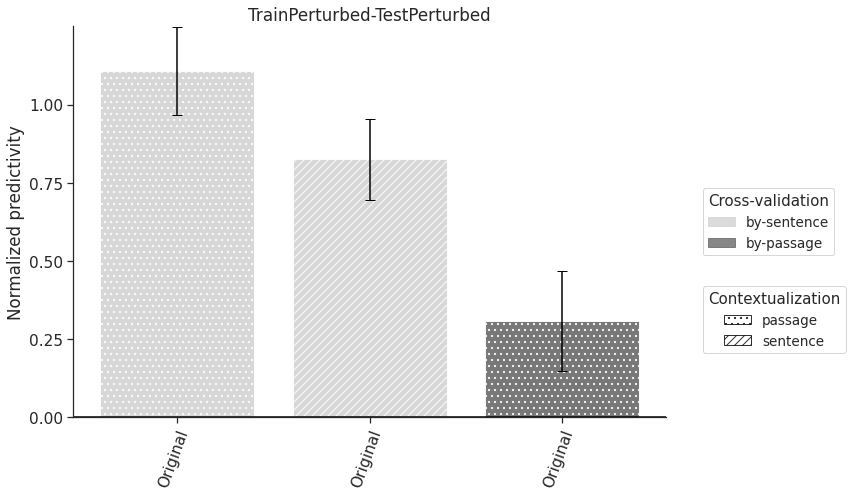

In [14]:
num_bars = 3
nrows = 1

fig2 = plt.figure(constrained_layout=True, figsize=(12, 7), facecolor='white')
spec2 = GridSpec(ncols=1, nrows=nrows, figure=fig2)
f2_ax = []

f2_ax.append(fig2.add_subplot(spec2[0, 0]))

x_pos = np.arange(len(full_df))
scores = list(full_df['score'])
errors = list(full_df['error'])
conditions = list(full_df['condition'])
cvs = list(full_df['cross-validation'])
emb_contexts = list(full_df['embedding context'])

colors = [CV2COLOR[elm] for elm in cvs]
hatches = [CV2HATCH[elm] for elm in emb_contexts]

f2_ax[-1].bar(x_pos, scores,
    yerr=errors,
    align='center',
    alpha=0.9, #color intensity
    ecolor='black',
    capsize=5, #error-bar width
    color=colors,
    hatch=hatches)

#reference_df = full_df.loc[full_df["cross-validation"]=="by-sentence"]
#add horizontal lines for original and random-wl
#orig_score = reference_df[reference_df["condition"]=="Original"]["score"].item()
#f2_ax[-1].axhline(y=orig_score, color="lightgray", linestyle=':', dashes=(5, 3), linewidth=1)

f2_ax[-1].axhline(y=0, color="black")
f2_ax[-1].set_ylim([0, 1.25])

# map names to colors
cmap = dict(zip(cvs, colors))
cmap = {k: v for k, v in cmap.items()}
# create the rectangles for the legend
from matplotlib.patches import Patch

patches = [Patch(color=v, label=k, alpha=0.8) for k, v in cmap.items()]

# add the legend
first_legend = f2_ax[-1].legend(title=f'Cross-validation', labels=cmap.keys(), handles=patches, bbox_to_anchor=(1.05, 0.5),
             loc='center left', title_fontsize=15, prop={'size': 13.5})
plt.gca().add_artist(first_legend)

# add second legend
hatchmap = dict(zip(emb_contexts, hatches))
hatchmap = {k: v for k, v in hatchmap.items()}
patches2 = [Patch(edgecolor="black", facecolor="white", hatch=v, label=k, alpha=0.8) for k, v in hatchmap.items()]
f2_ax[-1].legend(title=f'Contextualization', labels=hatchmap.keys(), handles=patches2, bbox_to_anchor=(1.05, 0.25),
             loc='center left', title_fontsize=15, prop={'size': 13.5}) 

# TICKS
## to get current ones: f2_ax[-1].get_yticks()
yticks = [0, 0.25, 0.5, 0.75, 1]
f2_ax[-1].set_yticks(yticks)
#set yticks
f2_ax[-1].set_xticks(list(range(num_bars)))
xticknames = ["\nFrom".join(elm.split("From")) for elm in conditions]
f2_ax[-1].set_xticklabels([x for x in xticknames if x], rotation=70, ha="right", rotation_mode="anchor")

f2_ax[-1].set_ylabel('Normalized predictivity')
f2_ax[-1].set_title('TrainPerturbed-TestPerturbed')

plt.tight_layout()
plt.savefig('results_paper/SupplementaryInformation/cv_by_passage.svg', dpi=300)
plt.savefig('results_paper/SupplementaryInformation/cv_by_passage.png', dpi=300)